#Initial setup
Setting up required libraries and other important google drive in order to work with files

In [ ]:
!pip install tensorflow opencv-python numpy matplotlib scikit-learn


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

dataset_path = '/content/drive/My Drive/Alzheimer\'s Dataset'
os.listdir(dataset_path)

FileNotFoundError: [Errno 2] No such file or directory: "/content/drive/My Drive/Alzheimer's Dataset"

In [ ]:
train_dir = '/content/drive/My Drive/Alzheimer\'s Dataset/train'
test_dir = '/content/drive/My Drive/Alzheimer\'s Dataset/test'

# Define class names and labels
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
class_labels = {classes[i]: i for i in range(len(classes))}


In [ ]:
# Import necessary libraries
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import os
import matplotlib.pyplot as plt

# Check if GPU is available and print the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Define the data transformation pipeline
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])  # Normalize with VGG16 params
])

# Paths to the dataset
train_dir = '/content/drive/My Drive/Alzheimer\'s Dataset/train'
test_dir = '/content/drive/My Drive/Alzheimer\'s Dataset/test'

# Create the dataset instances
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class counts for weighting
class_counts = [717, 52, 1792, 2560]  # Number of samples in each class
total_samples = sum(class_counts)
class_weights = [total_samples / class_count for class_count in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Load pre-trained VGG16 model for feature extraction
vgg_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT).features
vgg_model = vgg_model.to(device)
vgg_model.eval()  # Set to evaluation mode

# Function to extract features using VGG16
def extract_features(loader):
    features = []
    labels = []
    with torch.no_grad():
        for (images, target) in loader:
            images = images.to(device)
            output = vgg_model(images)
            output = output.view(output.size(0), -1)
            features.append(output.cpu())
            labels.append(target)
            print(target)
    return torch.cat(features), torch.cat(labels)

# Extract features from the training and test set
train_features, train_labels = extract_features(train_loader)
test_features, test_labels = extract_features(test_loader)

# Create DataLoader for features
train_features_dataset = TensorDataset(train_features, train_labels)
test_features_dataset = TensorDataset(test_features, test_labels)

train_features_loader = DataLoader(train_features_dataset, batch_size=32, shuffle=True)
test_features_loader = DataLoader(test_features_dataset, batch_size=32, shuffle=False)

# Define the neural network classifier
class NeuralNetworkClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetworkClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 4096)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Define the model, loss function, and optimizer
input_size = train_features.size(1)
num_classes = len(train_dataset.classes)

model = NeuralNetworkClassifier(input_size, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training loop with progress display
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (features, labels) in enumerate(train_features_loader):
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_features_loader)}], Loss: {loss.item():.4f}')

    epoch_loss = running_loss / len(train_features_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}] completed, Average Loss: {epoch_loss:.4f}')

    model.eval()
    correct = 0
    total = 0
    running_val_loss = 0.0
    with torch.no_grad():
        for features, labels in test_features_loader:
            features = features.to(device)
            labels = labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_val_loss / len(test_features_loader)
    val_losses.append(val_loss)
    accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')

# Plot training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

print('Finished Training')


Using GPU: Tesla T4


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 170MB/s]


In [ ]:
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            resized_img = cv2.resize(img, (224, 224))
            images.append(resized_img)
            labels.append(label)
    return images, labels

In [ ]:

# Load training data
train_images = []
train_labels = []
for class_name in classes:
    folder = os.path.join(train_dir, class_name)
    images, labels = load_images_from_folder(folder, class_labels[class_name])
    train_images.extend(images)
    train_labels.extend(labels)




In [ ]:
# Load testing data
test_images = []
test_labels = []
for class_name in classes:
    folder = os.path.join(test_dir, class_name)
    images, labels = load_images_from_folder(folder, class_labels[class_name])
    test_images.extend(images)
    test_labels.extend(labels)

In [ ]:

# Convert lists to numpy arrays
train_images = np.array(train_images) / 255.0
train_labels = np.array(train_labels)
test_images = np.array(test_images) / 255.0
test_labels = np.array(test_labels)


In [ ]:
# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

print(f"Training data: {X_train.shape}, Training labels: {y_train.shape}")
print(f"Validation data: {X_val.shape}, Validation labels: {y_val.shape}")
print(f"Testing data: {test_images.shape}, Testing labels: {test_labels.shape}")

Training data: (4104, 224, 224, 3), Training labels: (4104,)
Validation data: (1027, 224, 224, 3), Validation labels: (1027,)
Testing data: (1279, 224, 224, 3), Testing labels: (1279,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Build a simple CNN model
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compile the model
model_cnn.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Train the model
history_cnn = model_cnn.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Evaluate the model
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(test_images, test_labels)
print(f'\nCNN Test accuracy: {test_acc_cnn}')


Epoch 1/10
129/129 [==============================] - 55s 417ms/step - loss: 1.0787 - accuracy: 0.4730 - val_loss: 1.0925 - val_accuracy: 0.4869
Epoch 2/10
129/129 [==============================] - 52s 401ms/step - loss: 1.0556 - accuracy: 0.4961 - val_loss: 1.0789 - val_accuracy: 0.4869
Epoch 3/10
129/129 [==============================] - 52s 403ms/step - loss: 1.0478 - accuracy: 0.5007 - val_loss: 1.0752 - val_accuracy: 0.4869
Epoch 4/10
129/129 [==============================] - 53s 408ms/step - loss: 1.0406 - accuracy: 0.5034 - val_loss: 1.0697 - val_accuracy: 0.4869
Epoch 5/10
129/129 [==============================] - 52s 407ms/step - loss: 1.0460 - accuracy: 0.5044 - val_loss: 1.0670 - val_accuracy: 0.4869
Epoch 6/10
129/129 [==============================] - 51s 399ms/step - loss: 1.0370 - accuracy: 0.5022 - val_loss: 1.0516 - val_accuracy: 0.4869
Epoch 7/10
129/129 [==============================] - 51s 395ms/step - loss: 1.0152 - accuracy: 0.5044 - val_loss: 1.0595 - val_ac

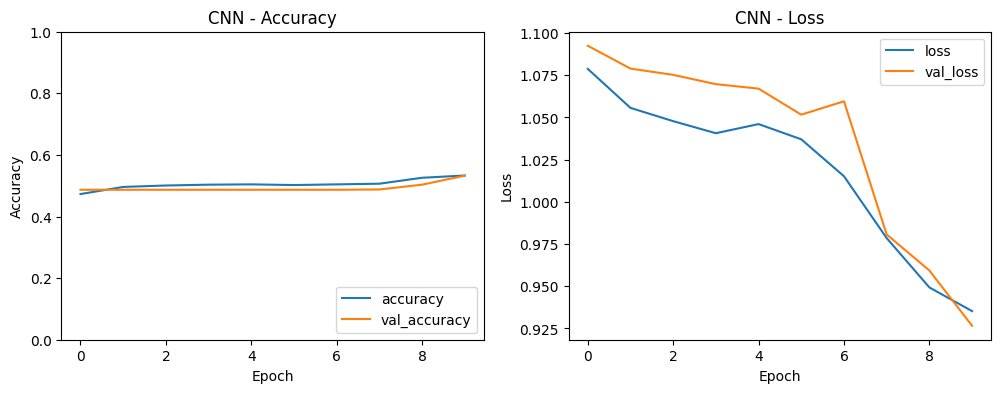

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title(f'{title} - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} - Loss')

    plt.show()

# Plot training history for CNN
plot_history(history_cnn, 'CNN')